/home/changcheng/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<IPython.core.display.Javascript object>


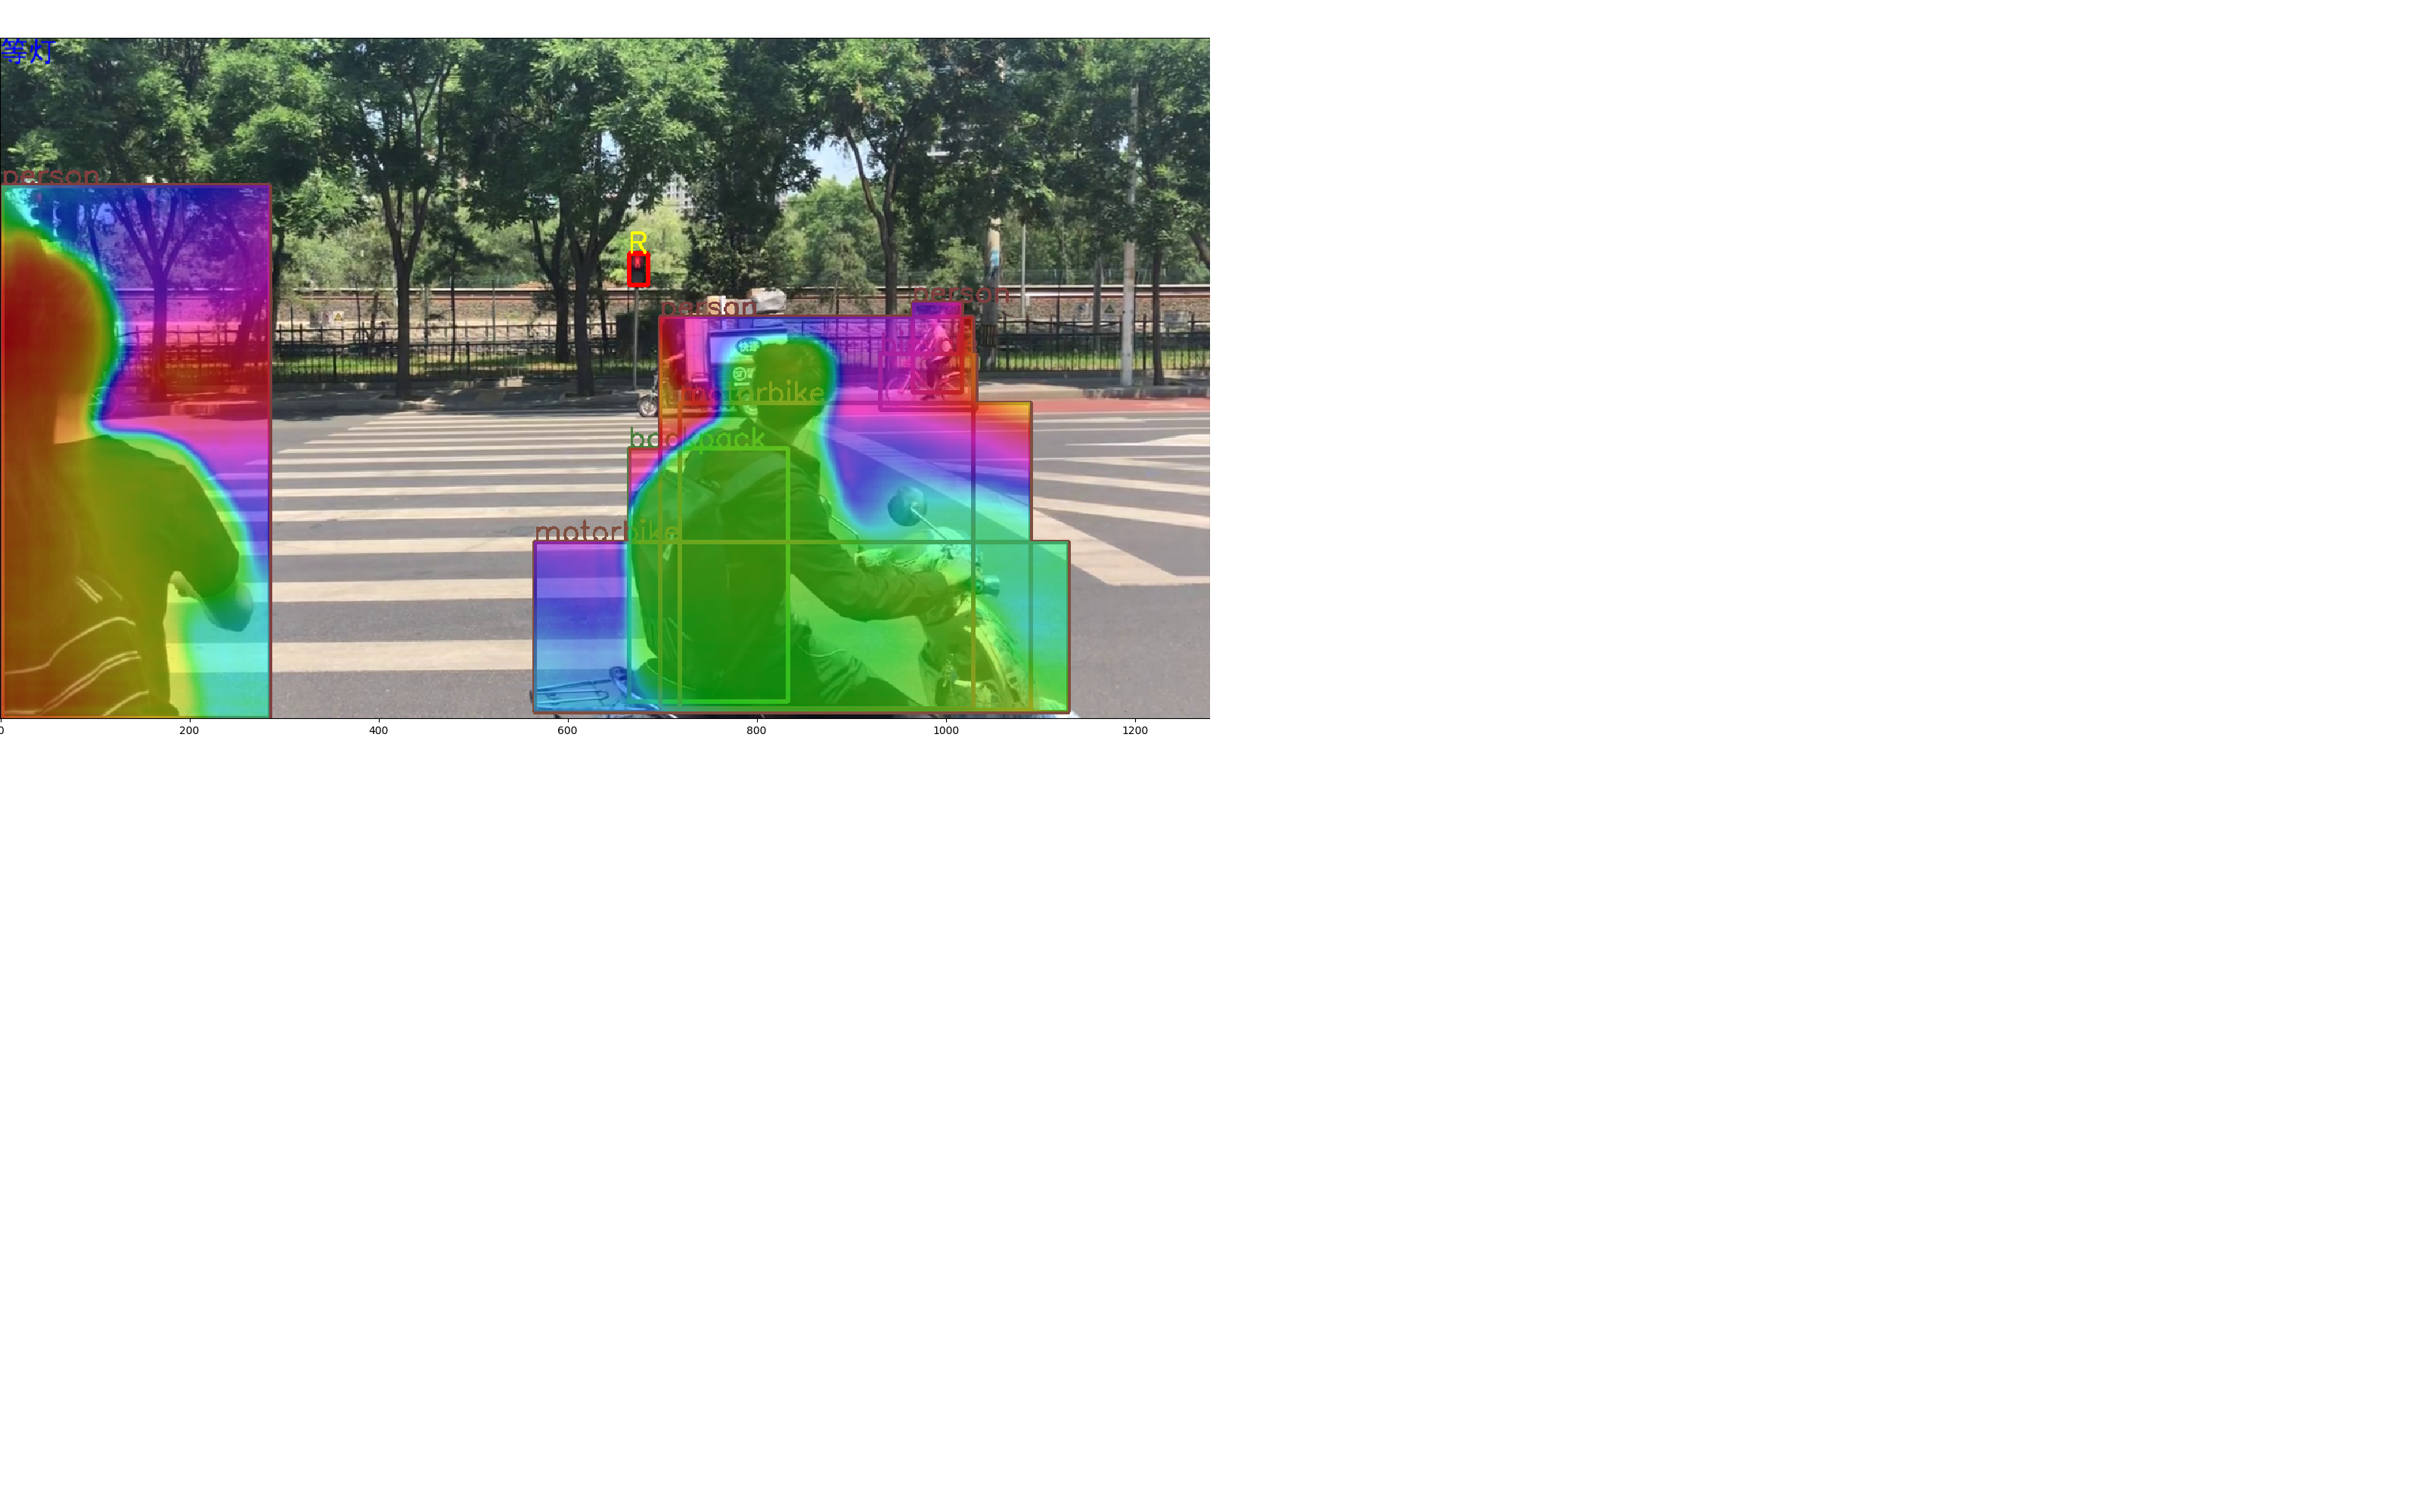

INFO:tensorflow:Restoring parameters from fcrn_depth_prediction/model/NYU_FCRN.ckpt
keras_yolo3/model_data/yolo.h5 model, anchors, and classes loaded.
get frame 0
(720, 1280, 3)
[[666 229 686 262]] [] [] [array([666, 229, 686, 262])] ['d']
Detected 1 traffic lights, in total 1 traffic lights, 6 obstacles
(1, 128, 160, 1)
['R']
['R']
G:  0 , R:  1 , B:  0 , State_HIST:  ['R'] R
Cur Max Pedestrain Light vote 0, Forward Max Pedestrain Light vote 1
(1, 128, 160, 1)


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


get frame 1
(720, 1280, 3)
[[666 229 686 263]] [[666 229 686 262]] [[0 0]] [array([666, 229, 686, 263])] ['d&t']
Detected 1 traffic lights, in total 1 traffic lights, 6 obstacles
(1, 128, 160, 1)
['R', 'R']
['R', 'R']
G:  0 , R:  2 , B:  0 , State_HIST:  ['R', 'R'] R
Cur Max Pedestrain Light vote 1, Forward Max Pedestrain Light vote 2


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(1, 128, 160, 1)
get frame 2
(720, 1280, 3)
[] [[666 229 686 262]] [] [array([666, 229, 686, 262])] ['t']
Detected 0 traffic lights, in total 1 traffic lights, 7 obstacles
(1, 128, 160, 1)
['R', 'R', 'R']
['R', 'R', 'R']
G:  0 , R:  3 , B:  0 , State_HIST:  ['R', 'R', 'R'] R
Cur Max Pedestrain Light vote 2, Forward Max Pedestrain Light vote 3
(1, 128, 160, 1)


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


get frame 3
(720, 1280, 3)
[] [[666 228 686 261]] [] [array([666, 228, 686, 261])] ['t']
Detected 0 traffic lights, in total 1 traffic lights, 7 obstacles
(1, 128, 160, 1)
['R', 'R', 'R', 'R']
['R', 'R', 'R', 'R']
G:  0 , R:  4 , B:  0 , State_HIST:  ['R', 'R', 'R', 'R'] R
Cur Max Pedestrain Light vote 3, Forward Max Pedestrain Light vote 4


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(1, 128, 160, 1)
get frame 4
(720, 1280, 3)
[] [[666 228 686 261]] [] [array([666, 228, 686, 261])] ['t']
Detected 0 traffic lights, in total 1 traffic lights, 7 obstacles
(1, 128, 160, 1)
['R', 'R', 'R', 'R', 'R']
['R', 'R', 'R', 'R', 'R']
G:  0 , R:  5 , B:  0 , State_HIST:  ['R', 'R', 'R', 'R', 'R'] R
Cur Max Pedestrain Light vote 4, Forward Max Pedestrain Light vote 5
(1, 128, 160, 1)


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


get frame 5
(720, 1280, 3)
[] [[665 228 685 261]] [] [array([665, 228, 685, 261])] ['t']
Detected 0 traffic lights, in total 1 traffic lights, 7 obstacles
(1, 128, 160, 1)
['R', 'R', 'R', 'R', 'R', 'R']
['R', 'R', 'R', 'R', 'R', 'R']
G:  0 , R:  6 , B:  0 , State_HIST:  ['R', 'R', 'R', 'R', 'R', 'R'] R
Cur Max Pedestrain Light vote 5, Forward Max Pedestrain Light vote 5


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(1, 128, 160, 1)
get frame 6
(720, 1280, 3)
[] [[666 228 686 261]] [] [array([666, 228, 686, 261])] ['t']
Detected 0 traffic lights, in total 1 traffic lights, 6 obstacles
(1, 128, 160, 1)
['R', 'R', 'R', 'R', 'R', 'R', 'R']
['R', 'R', 'R', 'R', 'R', 'R', 'R']
G:  0 , R:  7 , B:  0 , State_HIST:  ['R', 'R', 'R', 'R', 'R', 'R', 'R'] R
Cur Max Pedestrain Light vote 5, Forward Max Pedestrain Light vote 5
(1, 128, 160, 1)


/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/changcheng/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glue import BlindNavigator
from utility import read_video
from PIL import Image
import numpy as np
import cv2
import time

from visualization import Visualizer

class Visor(object):
    def __init__(self, form = 'OFFLINE'):
        self.form = form
        self.handler = None
        self.handler2 = None
        self.rescale = False
        self.output_size = (600, 400)
        self.im_size = self.output_size


        
    def initializer(self):
        if self.form == 'OFFLINE':
            self.fourcc = cv2.VideoWriter_fourcc(*'XVID')
            writer = None
            (h, w) = (None, None)
            self.handler = writer 
            
        else:
            fig = plt.figure(figsize=(16, 10))
            ax = fig.add_axes([0,0,1,1])

            plt.ion()
            fig.show()
            fig.canvas.draw()
            self.handler = fig
            self.handler2 = ax

            
    def inliner(self, im, save_path='./test.avi'):
        self.im_size = (im.shape[1], im.shape[0])
        (w, h) =  self.output_size

        if self.rescale:
            im = cv2.resize(im, (w, h),interpolation=cv2.INTER_CUBIC)
        else:
            (h, w) = im.shape[:2]

        if self.form == 'OFFLINE' and self.handler is None:
            self.handler = cv2.VideoWriter(save_path, self.fourcc, 30, (w, h), True)
        elif self.form != 'OFFLINE':
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im

    def drawer(self, im):
        if self.form == 'OFFLINE':
            self.handler.write(im)
        else:
            self.handler2.imshow(im)
            self.handler.canvas.draw()
            self.handler2.clear()
            
    def rescale_box(self, bbox):
        if self.rescale:
            bbox = np.array([bbox[0] / self.im_size[0] * self.output_size[0], \
                             bbox[1] / self.im_size[1] * self.output_size[1], \
                             bbox[2] / self.im_size[0] * self.output_size[0], \
                             bbox[3] / self.im_size[1] * self.output_size[1]])
        bbox = np.asarray(bbox).astype(int)
        return bbox
    
debuger = 'ONLINE'
def test_det_track():
    video_path = 'data/IMG_1051.MOV'
    save_path = 'IMG_1051_det_track.avi'

    visor = Visor(debuger)
    visor.initializer()

    navigator = BlindNavigator()
    timestamps = [time.time()]
    for data in read_video(video_path):
        timestamps.append(time.time())

        traffic_lights, detected_obstacles = navigator.detect_traffic_light(data)
        timestamps.append(time.time())
        print('Processing time: %.3f'%(timestamps[-1] - timestamps[-2]))
#         data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        data = visor.inliner(data, save_path)
        for (id_, bbox) in traffic_lights:
            bbox = visor.rescale_box(bbox)
            assert  id_ < len(navigator.traffic_light_pool.trackers), 'id_ not valid'
#             bbox = [bbox[0] / data.shape[1], bbox[1] / data.shape[0], bbox[2] / data.shape[1], bbox[3] / data.shape[0]]
#             print(bbox)
#             p = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, alpha=1)
#             ax.add_patch(p)
            cv2.rectangle(data, tuple(bbox[:2]),tuple(bbox[2:4]), [255, 0, 0], 3)
        visor.drawer(data)

def test_light_classifier(video_path, save_path):


    visor = Visor(debuger)
    visor.initializer()
    navigator = BlindNavigator()
    
    
    for data in read_video(video_path):
        traffic_lights, detected_obstacles = navigator.detect_traffic_light(data)
        light_states = navigator.color_classify_by_boxes(data, [light[1] for light in traffic_lights])
        
        data = visor.inliner(data, save_path)
        for (id_, bbox), state in zip(traffic_lights, light_states):
            
            bbox = visor.rescale_box(bbox)

            assert  id_ < len(navigator.traffic_light_pool.trackers), 'id_ not valid'
#             bbox = [bbox[0] / data.shape[1], bbox[1] / data.shape[0], bbox[2] / data.shape[1], bbox[3] / data.shape[0]]
#             print(bbox)
#             p = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, alpha=1)
#             ax.add_patch(p)
            cv2.rectangle(data, tuple(bbox[:2]),tuple(bbox[2:4]), [255, 0, 0], 3)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(data, '%s'%(state), (bbox[0]-1,bbox[1]-1), font, 1, color=(255,255,0), thickness=2)
        visor.drawer(data)

def test_zebra_contours(video_path, save_path):
  visor = Visor(debuger)
  visor.initializer()
  navigator = BlindNavigator()
  visualizer = Visualizer()
    
  cmap = {
        'LIGHT_WAIT': '等灯',
        'START_FORWARD':'开始前进',
        'CROSS_FORWARD':'继续前行',
        'CROSS_WAIT':'有障碍物',
        'ARRIVAL': '到达',
        
    }
  for data in read_video(video_path):
    import cv2 
    print(data.shape)
    #         import pdb
    #         pdb.set_trace()
    p_light, detected_obstacles, traffic_lights = navigator.executor(data)
    data = visor.inliner(data, save_path)
#     traffic_lights = []
    if 1 or p_light is not None:
#       bbox, state = p_lights.get_bbox(), p_lights.get_state()
#       traffic_lights.append((state, bbox))
      for bbox, state in zip(traffic_lights.get(), traffic_lights.get_field('states')):
          bbox = visor.rescale_box(bbox)
          #             assert  id_ < len(navigator.traffic_light_pool.trackers), 'id_ not valid'
          cv2.rectangle(data, tuple(bbox[:2]), tuple(bbox[2:4]), [255, 0, 0], 3)
          font = cv2.FONT_HERSHEY_SIMPLEX
          cv2.putText(data, '%s' % (state), (bbox[0] - 1, bbox[1] - 1), font, 1, color=(255, 255, 0), thickness=2)

    for j in navigator.zebra_contours:
#       import pdb
#       pdb.set_trace()
      bx, by, bw, bh = cv2.boundingRect(j)

      [bx, by, bw, bh] = visor.rescale_box([bx, by, bw, bh])
      cv2.rectangle(data, (bx, by), (bx + bw, by + bh), (180, 237, 167), -1)

    depth = navigator.depth_estimator.predict(data)
    
    obs_cls = detected_obstacles.get_field('classes')
    obs_boxes = detected_obstacles.get()
    

    data = visualizer.plot(data, obs_cls, obs_boxes, depth, [], navigator.is_stable, navigator.zebra_contours)
    
    data = cv2.cvtColor(data, cv2.COLOR_BGRA2BGR)
    
    text = cmap[navigator.state]
    
    from PIL import Image, ImageDraw, ImageFont

    cv2_im = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) # cv2和PIL中颜色的hex码的储存顺序不同
    pil_im = Image.fromarray(cv2_im)

    draw = ImageDraw.Draw(pil_im) # 括号中为需要打印的canvas，这里就是在图片上直接打印
    font = ImageFont.truetype("simhei.ttf", 30, encoding="utf-8") # 第一个参数为字体文件路径，第二个为字体大小
    draw.text((0, 0), text, (255, 0, 0), font=font) # 第一个参数为打印的坐标，第二个为打印的文本，第三个为字体颜色，第四个为字体

    data = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)

    visor.drawer(data)

if __name__ == '__main__':
    video_path = 'data/trim-9033.m4v'
    save_path = 'trim-9033_zebra_track.avi'
    test_zebra_contours(video_path, save_path)